<a href="https://colab.research.google.com/github/ygh1025/demo-repo/blob/main/tensorflow_week4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LSTM,GRU,Dense,GlobalAveragePooling1D,Flatten,Lambda,Bidirectional
from tensorflow.keras import Sequential

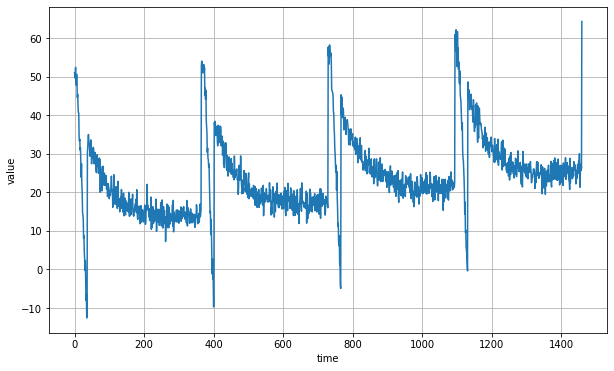

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
  plt.plot(time[start:end],series[start:end],format)
  plt.xlabel('time')
  plt.ylabel('value')
  plt.grid(True)
def trend(time, slope=0):
  return time*slope
def seasonal_pattern(season_time):
  return np.where(season_time < 0.1,
                    np.cos(season_time * 7 * np.pi),
                    1 / np.exp(5 * season_time))  
def seasonality(time, period, amplitude=1, phase=0):
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)
  
def noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.01
noise_level = 2

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

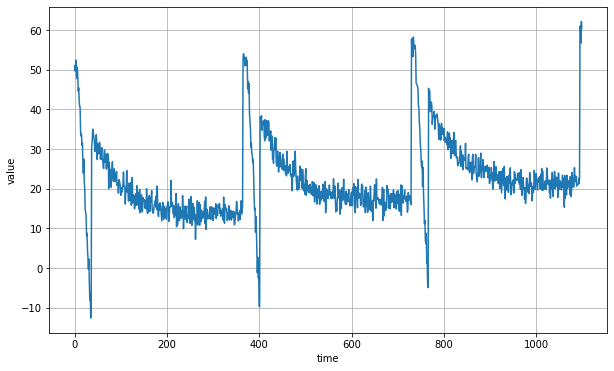

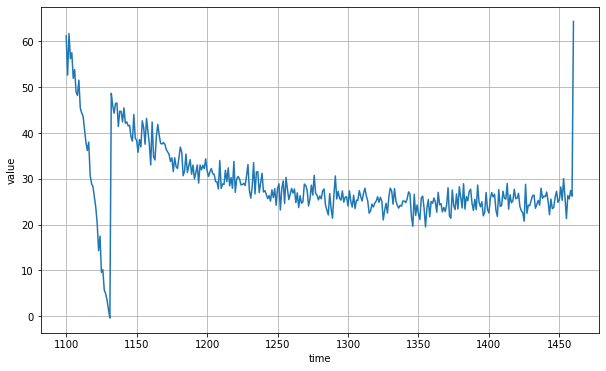

In [3]:
split_time = 1100
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plt.show()

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plt.show()



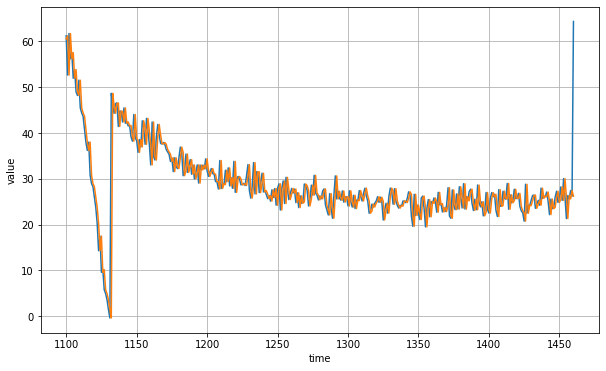

In [ ]:
naive_forecast = series[split_time-1:-1]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast)


In [ ]:
print(keras.metrics.mean_squared_error(x_valid,naive_forecast).numpy())
print(keras.metrics.mean_absolute_error(x_valid,naive_forecast).numpy())
# Expected Output
# 19.578304
# 2.6011968

19.578306
2.6011972


In [ ]:
type(series)

numpy.ndarray

In [ ]:
def moving_average_forecast(series, window_size):
  mv=[]
  for i in range(len(series)-window_size):
    mv.append(series[i:i+window_size].mean())
  return np.array(mv)


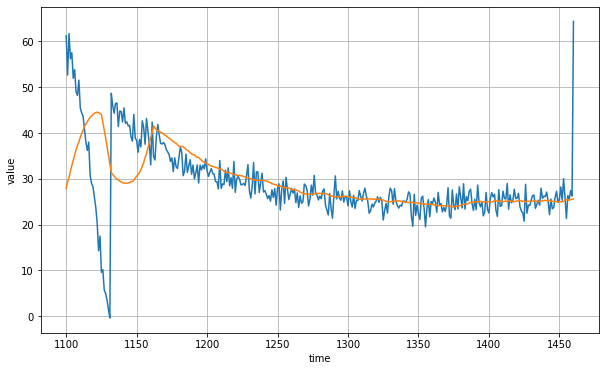

In [17]:
window_size=30
moving_avg = moving_average_forecast(series,window_size)[split_time-window_size:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)


In [18]:
print(keras.metrics.mean_squared_error(x_valid,moving_avg).numpy())
print(keras.metrics.mean_absolute_error(x_valid,moving_avg).numpy())
# EXPECTED OUTPUT
# 8.498155
# 2.327179


65.78622
4.3040023


In [16]:
x_train

array([50.993427, 49.660896, 51.025326, ..., 56.683544, 62.161026,
       60.526978], dtype=float32)

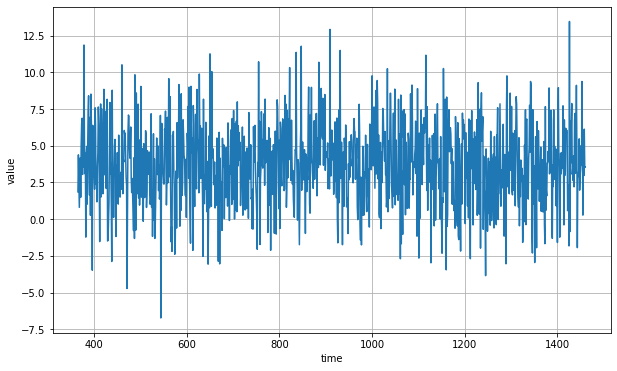

In [21]:
diff_series = series[365:]-series[:-365]
diff_time = time[365:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)
plt.show()


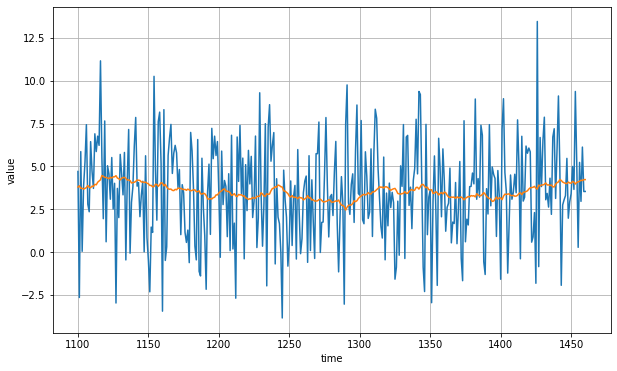

In [45]:
diff_moving_avg = moving_average_forecast(diff_series,50)

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time-365:])
plot_series(time_valid, diff_moving_avg[split_time-365-50:])
plt.show()


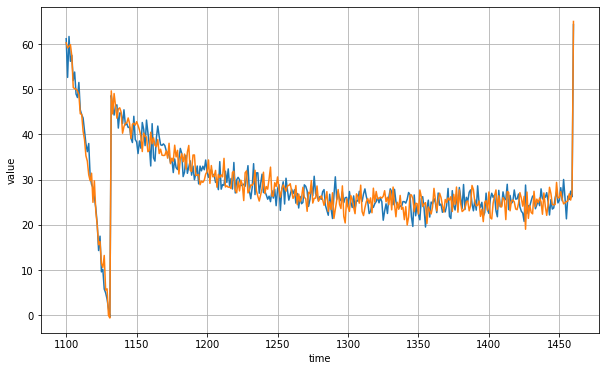

In [46]:
diff_moving_avg_plus_past = diff_moving_avg[split_time-365-50:]+series[split_time-365:-365]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_past)
plt.show()


In [47]:
print(keras.metrics.mean_squared_error(x_valid,diff_moving_avg_plus_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid,diff_moving_avg_plus_past).numpy())


8.498155
2.3271792


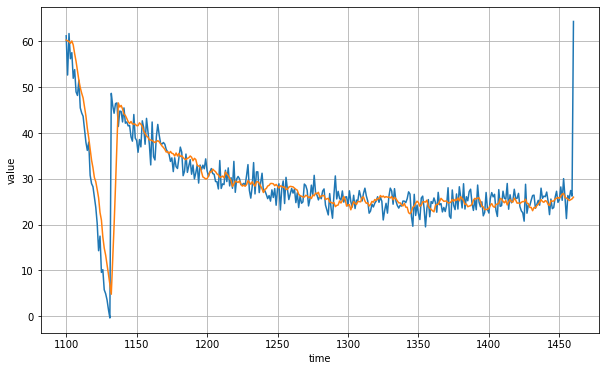

In [51]:
diff_moving_avg_plus_smooth_past =  diff_moving_avg[split_time-365-50:]+moving_average_forecast(series[split_time-365-5:-365],5)

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past)
plt.show()


In [52]:
print(keras.metrics.mean_squared_error(x_valid,diff_moving_avg_plus_smooth_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid,diff_moving_avg_plus_smooth_past).numpy())


23.00328
2.5356562


In [4]:
window_size=20

In [5]:
def window_data(series,windows,batch_size,buffer_size):
  dataset=tf.data.Dataset.from_tensor_slices(series)
  dataset=dataset.window(windows+1,shift=1,drop_remainder=True)
  dataset=dataset.flat_map(lambda x:x.batch(windows+1))
  dataset=dataset.map(lambda x:(x[:-1],x[-1]))
  dataset=dataset.shuffle(buffer_size)
  dataset=dataset.batch(batch_size).prefetch(1)
  return dataset

In [6]:
datasets = window_data(list(x_train), window_size, 30, 1000)

In [24]:
datasets.shape

AttributeError: ignored

In [21]:
tf.keras.backend.clear_session()

In [58]:
model=Sequential([Lambda(lambda x:tf.expand_dims(x,2),input_shape=[None]),
                  Bidirectional(LSTM(64,return_sequences=True)),
                  Bidirectional(LSTM(64)),

                  Dense(128,activation='relu'),
                  Dense(64,activation='relu'),
                  Dense(1),
                  Lambda(lambda x:x*100)
])
lr_scheduler=tf.keras.callbacks.LearningRateScheduler(lambda epoch:1e-8*10**(epoch/20))
model.compile(loss=tf.keras.losses.Huber(),optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-8,momentum=0.9),metrics=['mae'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_12 (Lambda)          (None, None, 1)           0         
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        33792     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_18 (Dense)            (None, 128)               16512     
                                                                 
 dense_19 (Dense)            (None, 64)                8256      
                                                                 
 dense_20 (Dense)            (None, 1)                

In [59]:

hist=model.fit(datasets,epochs=100,callbacks=[lr_scheduler])

Epoch 1/100
36/36 [==============================] - 6s 30ms/step - loss: 36.2170 - mae: 36.7170 - lr: 1.0000e-08
Epoch 2/100
36/36 [==============================] - 1s 30ms/step - loss: 36.0235 - mae: 36.5235 - lr: 1.1220e-08
Epoch 3/100
36/36 [==============================] - 1s 29ms/step - loss: 35.8143 - mae: 36.3143 - lr: 1.2589e-08
Epoch 4/100
36/36 [==============================] - 1s 31ms/step - loss: 35.5807 - mae: 36.0807 - lr: 1.4125e-08
Epoch 5/100
36/36 [==============================] - 1s 30ms/step - loss: 35.3197 - mae: 35.8196 - lr: 1.5849e-08
Epoch 6/100
36/36 [==============================] - 1s 30ms/step - loss: 35.0268 - mae: 35.5267 - lr: 1.7783e-08
Epoch 7/100
36/36 [==============================] - 1s 30ms/step - loss: 34.7010 - mae: 35.2007 - lr: 1.9953e-08
Epoch 8/100
36/36 [==============================] - 1s 30ms/step - loss: 34.3368 - mae: 34.8364 - lr: 2.2387e-08
Epoch 9/100
36/36 [==============================] - 1s 31ms/step - loss: 33.9279 - mae:

In [61]:
model.compile(loss='mse',optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-5,momentum=0.9),metrics=['mae'])
hist2=model.fit(datasets,epochs=100)

Epoch 1/100
36/36 [==============================] - 7s 31ms/step - loss: 15.1939 - mae: 2.2452
Epoch 2/100
36/36 [==============================] - 1s 31ms/step - loss: 14.7216 - mae: 2.1958
Epoch 3/100
36/36 [==============================] - 1s 31ms/step - loss: 14.4047 - mae: 2.1608
Epoch 4/100
36/36 [==============================] - 1s 31ms/step - loss: 14.2596 - mae: 2.1373
Epoch 5/100
36/36 [==============================] - 1s 32ms/step - loss: 13.9999 - mae: 2.1266
Epoch 6/100
36/36 [==============================] - 1s 31ms/step - loss: 13.8179 - mae: 2.0930
Epoch 7/100
36/36 [==============================] - 1s 30ms/step - loss: 13.6725 - mae: 2.0712
Epoch 8/100
36/36 [==============================] - 1s 31ms/step - loss: 13.5246 - mae: 2.0511
Epoch 9/100
36/36 [==============================] - 1s 31ms/step - loss: 13.4517 - mae: 2.0506
Epoch 10/100
36/36 [==============================] - 1s 30ms/step - loss: 13.3612 - mae: 2.0390
Epoch 11/100
36/36 [===================

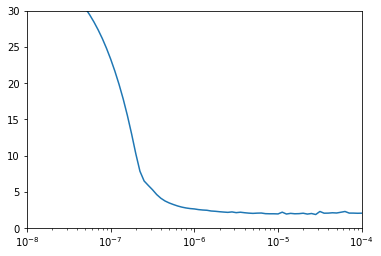

In [60]:
plt.semilogx(hist.history['lr'],hist.history['loss'])
plt.axis([1e-8,1e-4,0,30])
plt.show()

In [62]:
forcast=[]
#time=0
for time in range(len(series)-window_size):
  forcast.append(model.predict((series[time:time+window_size]).reshape(1,-1)))

In [16]:
np.array(forcast[:5]).reshape(-1)

array([23.2961  , 21.973932, 20.391941, 17.386494, 13.43901 ],
      dtype=float32)

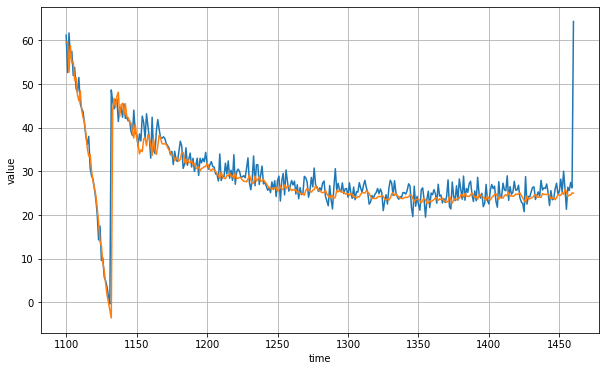

In [63]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, np.array(forcast).reshape(-1)[split_time-20:])
plt.show()


In [64]:
print(keras.metrics.mean_squared_error(x_valid,np.array(forcast).reshape(-1)[split_time-20:]).numpy())
print(keras.metrics.mean_absolute_error(x_valid,np.array(forcast).reshape(-1)[split_time-20:]).numpy())


17.834896
2.1381044


In [66]:
import csv

In [65]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2022-05-08 02:18:22--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.004s  

2022-05-08 02:18:22 (14.7 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



In [74]:
with open('/tmp/daily-min-temperatures.csv','r') as file:
  temp=[]
  lines=csv.reader(file)
  next(lines)
  for lin in lines:
    temp.append(float(lin[1]))
time=list(range(len(temp)))


In [73]:
temp[:5]

[20.7, 17.9, 18.8, 14.6, 15.8]

In [75]:
series=np.array(temp)
time=np.array(time)

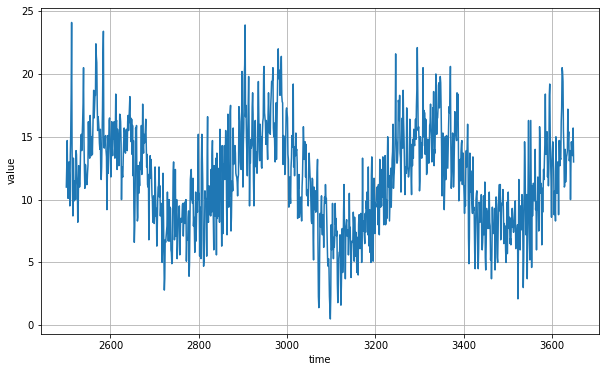

In [107]:
plt.figure(figsize=(10,6))
plot_series(time_valid,x_valid)

In [106]:
split_time = 2500
x_train=series[:split_time]
time_train=time[:split_time]
x_valid=series[split_time:]
time_valid=time[split_time:]
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [82]:
def window_data(series,window_size,batch_size,shuffle_buffer_size):
  data=tf.data.Dataset.from_tensor_slices(series)
  data=data.window(window_size+1,shift=1,drop_remainder=True)
  data=data.flat_map(lambda x:x.batch(window_size+1))
  data=data.map(lambda x:(x[:-1],x[-1]))
  data=data.shuffle(shuffle_buffer_size)
  data=data.batch(batch_size).prefetch(0)
  return data

In [97]:
def model_forecast(model, series, window_size):
  forcast=[]
  for time in range(len(series)-window_size):
    forcast.append(model.predict(series[time:time+window_size].reshape(1,-1)))
  return np.array(forcast).reshape(-1)


In [113]:
tf.keras.backend.clear_session()
window_size = 64
batch_size = 256
train_set = window_data(x_train, window_size, batch_size, shuffle_buffer_size)
lr_schedule=tf.keras.callbacks.LearningRateScheduler(lambda epoch:1e-8*10**(epoch/20))
op=tf.keras.optimizers.RMSprop(learning_rate=1e-6,momentum=0.9)
model=Sequential([
                  Lambda(lambda x:tf.expand_dims(x,2),input_shape=[None]),
                  Bidirectional(LSTM(64,return_sequences=True)),
                  Bidirectional(LSTM(64)),
                  Dense(64,activation='relu'),
                  Dense(1),
                  Lambda(lambda x:x*30)
])
model.compile(loss=tf.keras.losses.Huber(),optimizer=op,metrics=['mae'])




In [91]:
hist=model.fit(train_set,epochs=100,callbacks=[lr_schedule])

Epoch 1/100
10/10 [==============================] - 45s 423ms/step - loss: 2.3928 - mae: 2.8569 - lr: 1.0000e-08
Epoch 2/100
10/10 [==============================] - 4s 416ms/step - loss: 2.3839 - mae: 2.8477 - lr: 1.1220e-08
Epoch 3/100
10/10 [==============================] - 4s 425ms/step - loss: 2.3738 - mae: 2.8374 - lr: 1.2589e-08
Epoch 4/100
10/10 [==============================] - 4s 421ms/step - loss: 2.3630 - mae: 2.8262 - lr: 1.4125e-08
Epoch 5/100
10/10 [==============================] - 4s 414ms/step - loss: 2.3515 - mae: 2.8145 - lr: 1.5849e-08
Epoch 6/100
10/10 [==============================] - 4s 417ms/step - loss: 2.3391 - mae: 2.8017 - lr: 1.7783e-08
Epoch 7/100
10/10 [==============================] - 4s 414ms/step - loss: 2.3254 - mae: 2.7874 - lr: 1.9953e-08
Epoch 8/100
10/10 [==============================] - 4s 420ms/step - loss: 2.3105 - mae: 2.7719 - lr: 2.2387e-08
Epoch 9/100
10/10 [==============================] - 4s 415ms/step - loss: 2.2942 - mae: 2.7549

(1e-10, 0.01, 0.0, 5.0)

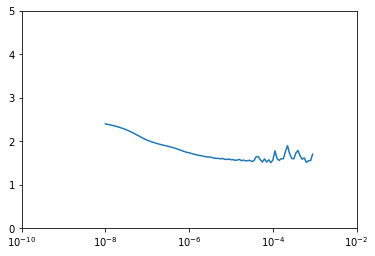

In [94]:
plt.semilogx(hist.history['lr'],hist.history['loss'])
plt.axis([1e-10,1e-2,0,5])

In [95]:
model.compile(loss='mse',optimizer=tf.keras.optimizers.RMSprop(learning_rate=8e-5,momentum=0.9),metrics=['mae'])
hist2=model.fit(train_set,epochs=50)

Epoch 1/50
10/10 [==============================] - 11s 421ms/step - loss: 6.4948 - mae: 1.9898
Epoch 2/50
10/10 [==============================] - 4s 417ms/step - loss: 6.4553 - mae: 1.9865
Epoch 3/50
10/10 [==============================] - 5s 472ms/step - loss: 6.0588 - mae: 1.9151
Epoch 4/50
10/10 [==============================] - 4s 417ms/step - loss: 6.0045 - mae: 1.9195
Epoch 5/50
10/10 [==============================] - 4s 414ms/step - loss: 5.9306 - mae: 1.8984
Epoch 6/50
10/10 [==============================] - 4s 418ms/step - loss: 5.9252 - mae: 1.9071
Epoch 7/50
10/10 [==============================] - 4s 413ms/step - loss: 5.9052 - mae: 1.8964
Epoch 8/50
10/10 [==============================] - 4s 419ms/step - loss: 5.9795 - mae: 1.9131
Epoch 9/50
10/10 [==============================] - 4s 415ms/step - loss: 5.8901 - mae: 1.8999
Epoch 10/50
10/10 [==============================] - 4s 425ms/step - loss: 5.8620 - mae: 1.8935
Epoch 11/50
10/10 [=============================

In [98]:
foc=model_forecast(model,series,window_size)

In [112]:
window_size

30

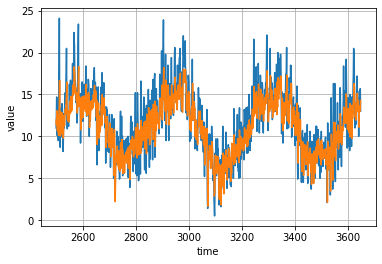

In [114]:
plot_series(time_valid,x_valid)
plot_series(time_valid,foc[split_time-window_size:])

In [115]:
tf.keras.metrics.mean_absolute_error(x_valid, foc[split_time-window_size:]).numpy()


1.8138835